# House Prices - Advanced Regression Techniques

The objective of this challenge is to build a regression model to predict the final price of homes in the dataset.

The dataset has 79 features, describing the characteristics of each given house. The description of each feature can be found in the [data_description.txt](./data/data_description.txt) file.

We will approach the problem in different steps:
1. Load the dataset and describe it
2. Data cleaning (e.g. remove nulls, feature encoding, etc.)
3. Train & Evaluate (rmse, r-squared)
4. Results
5. [Bonus] Improving our Kaggle score, where we try to improve the score with advanced techniques

# 1. Load the dataset and describe it

We are given two datasets, one called `train.csv` and the other `test.csv`. The `train.csv` dataset will be used for training, whereas the `test.csv` to create our final submission to Kaggle.

In [1]:
# Imports for the project

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

random_state = 13427895

In [2]:
train_dataset_raw = pd.read_csv('./data/train.csv', index_col='Id')
test_dataset_raw = pd.read_csv('./data/test.csv', index_col='Id')

train_dataset_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [3]:
train_dataset_raw.sample(8, random_state=random_state)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1245,70,RL,NaN,11435,Pave,NaN,IR1,HLS,AllPub,Corner,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,230000
974,20,FV,95.0,11639,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,12,2008,New,Partial,182000
257,60,FV,64.0,8791,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,207500
452,20,RL,62.0,70761,Pave,NaN,IR1,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,280000
1412,50,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,9,2009,WD,Normal,140000
958,20,RL,70.0,7420,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2007,WD,Normal,132000
671,60,RL,64.0,8633,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,2,2009,WD,Normal,173500
1219,50,RM,52.0,6240,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,80500


In [4]:
missing = train_dataset_raw.isna().sum()

missing[missing > 0]

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Looking at the output and in accordance with the [data_description.txt](/data/data_description.txt) file we can observe that the dataset:

- Contains many features with missing values. Now, should these columns or rows that contain them be dropped? We will have to distinguish whether the missing data actually is actually relevant.
    - For example, looking at the **PoolQC** feature, it indicates the PoolQuality. If **NaN** it indicates that the house does not have a pool, therefore is a useful information that we want to keep
    - Whereas, we see that for example **MasVnrArea** indicates the veneer area in square feet, a **NaN** value here means that we do not have that information, therefore we could either set it to zero or remove completely.

    In summary:
    1. These columns **Alley, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PoolQC, Fence, MiscFeature, MasVnrType** are _absent_, but contain meaningful information
    2. **Electrical** column is actually missing (1 row), therefore we will simply remove it from the dataset
    3. **LotFrontage** column is missing in 259 rows. In this case we won't delete the rows since it would mean deleting roughly 20% of the dataset. Therefore, we will set the missing values to the median of the rows with values

- Contains many categorical features, which we will likely need to encode.

## 1.1 Target Variable

The target variable 'y' in the dataset is **SalePrice**

In [5]:
target_column = 'SalePrice'

train_dataset_raw[target_column].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

We observe that the **mean** (180921) is higher than the **median** (50% - 163000), which could mean that there are some houses that are driving the price up (max 755000) which could indicate that the data is skewed towards the right. To confirm this, let's plot the data.

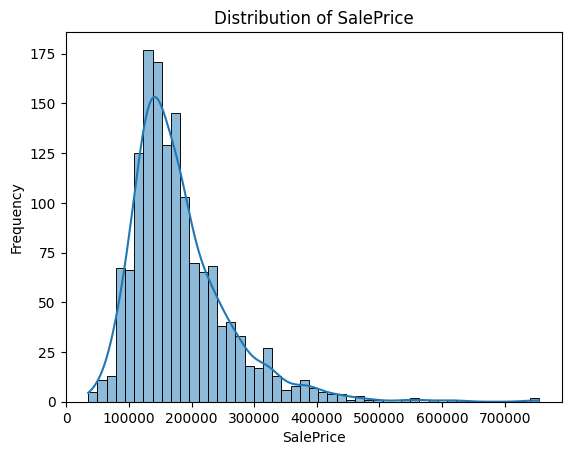

In [6]:
sns.histplot(train_dataset_raw[target_column], kde=True)
plt.title(f"Distribution of {target_column}")
plt.xlabel(target_column)
plt.ylabel("Frequency")

plt.show()

And indeed we observe that the data is right-skewed. We will need to appy a transformation to make it less "unbalanced".

## 1.2 Correlation

Let's go on and see the how the different columns contribute to the **SalePrice** target column by using correlation.

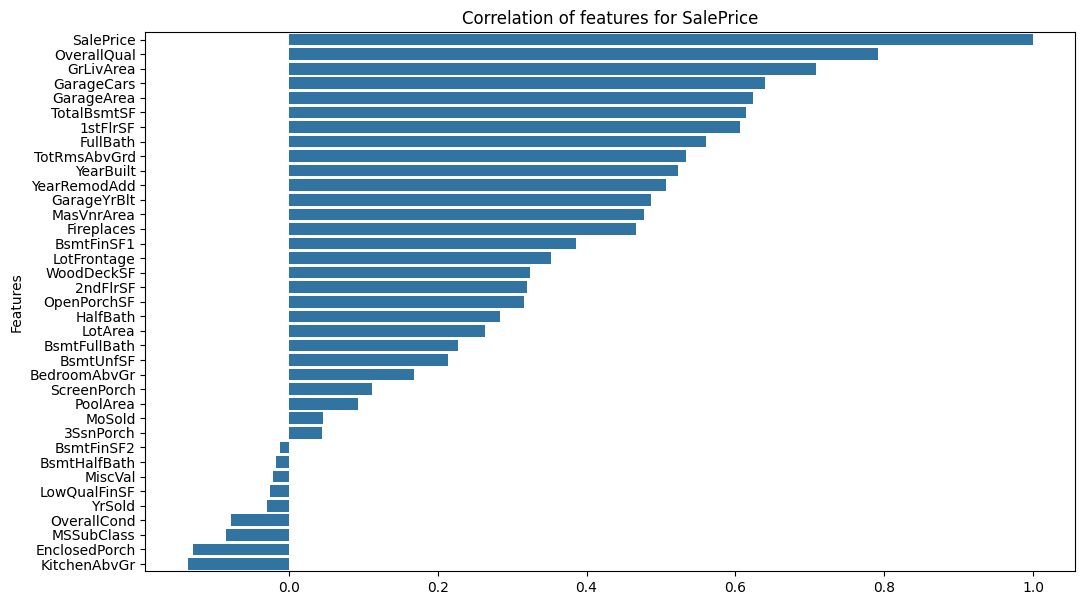

In [7]:
corr_matrix = train_dataset_raw.corr(numeric_only=True)
saleprice_correlations = corr_matrix[target_column].sort_values(ascending=False)

plt.figure(figsize=(12,7))
sns.barplot(x=saleprice_correlations.values, y=saleprice_correlations.index)
plt.title(f"Correlation of features for {target_column}")
plt.ylabel("Features")
plt.show()

Based on this visualization we can see that some features heavily (> .6) contribute to the **SalePrice** target

In [8]:
saleprice_correlations[saleprice_correlations > .6]

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
1stFlrSF       0.605852
Name: SalePrice, dtype: float64

Knowing this, let's see if these highly-correlated features have outliers using scatter plots.

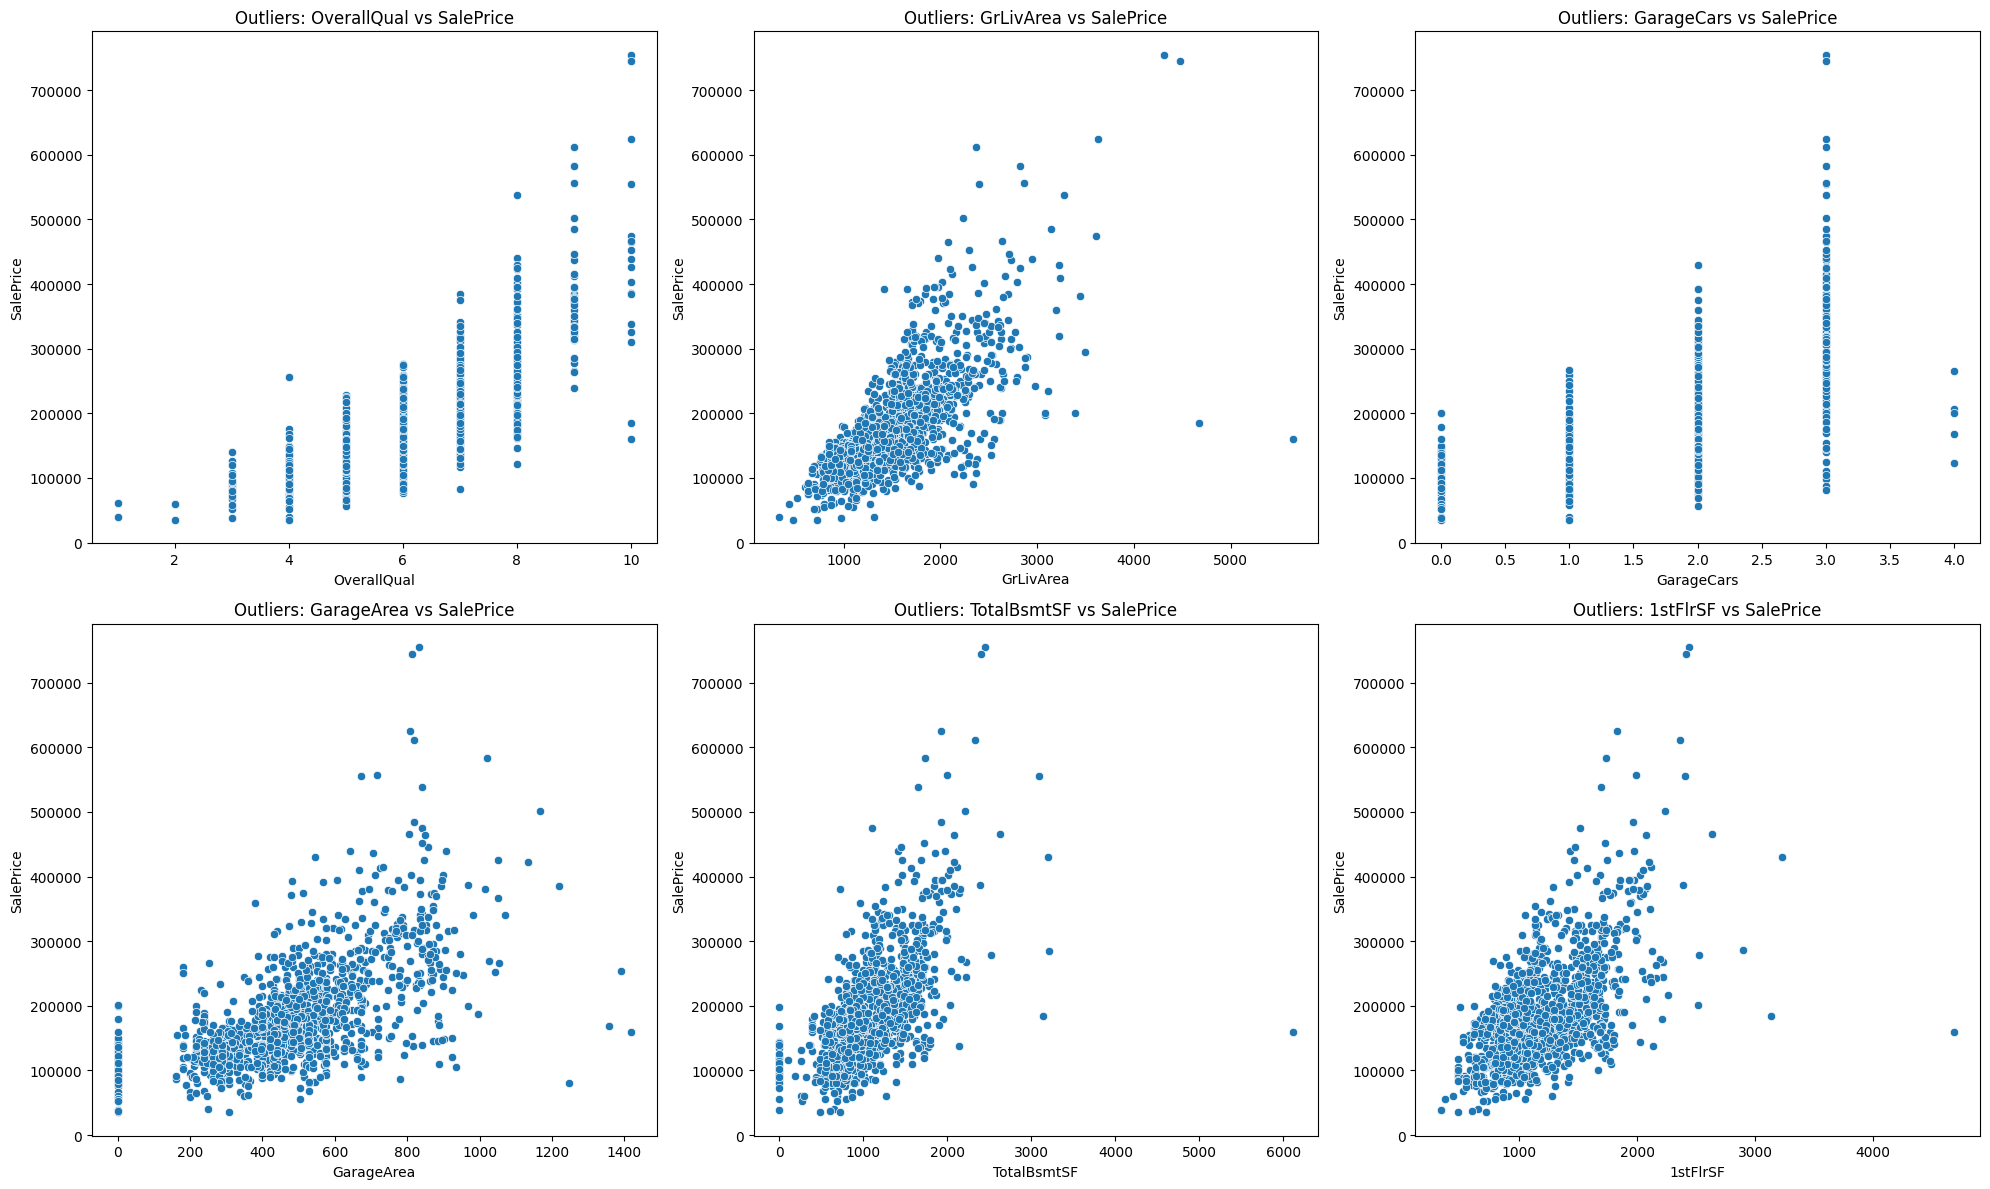

In [9]:
highly_correlated = saleprice_correlations[saleprice_correlations > .6]
highly_correlated = highly_correlated[1:] # remove the target column

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

for feature, ax in zip(highly_correlated.keys(), axes.flatten()):
    sns.scatterplot(x=train_dataset_raw[feature], y=train_dataset_raw[target_column], ax=ax)
    
    ax.set_title(f"Outliers: {feature} vs {target_column}")

plt.tight_layout()
plt.show()

Looking at this we see some outliers for:
- **GrLivArea** where two houses with a > 4500ft sq. are are sold at < 200000 dollars. We will remove this as it doesn't make much sense if we think at the context we are working in. A house that big should cost way more money, but here it is sold very cheap.
- **GarageArea** where houses with a > 1200ft sq. are sold at < 300000 dollars. This is more nuanced as it's plausible that a real house might have an enormous garage or workshop. We will leave this outsider to be conservative and later see if it was the right decision.
- **TotalBSmtSF** & **1stFlrSF** with a really out-of-charts outliers, most certainly an error in the data.

# 2. Data Cleaning

RECAP: In the previous phase, we identified several items that we need to address:
- **Missing Data**, We found numerous columns with missing values and determined that some `NaN`s represent a meaningful absence of a feature (e.g., no pool), while others are truly missing data points.
- **Outliers**, We identified a few significant outliers, particularly two data points with very large **GrLivArea** but unusually low **SalePrice**, which could negatively impact model performance.
- **Target Variable Skewness**, Our target variable, **SalePrice**, is heavily right-skewed and will need to be transformed to be more suitable for linear models.

In this section, we will execute a cleaning plan based on these findings. The process will be as follows:
1. First, we will handle all missing data by either **imputing** values or **dropping** rows.
2. Second, we will **remove** the identified outliers from the dataset.
3. Third, we will apply a log transformation to the **SalePrice** column to normalize its distribution.
4. Finally, once the data is clean, we will perform **feature encoding** to convert categorical columns into a numerical format that machine learning models can process.

### 2.1 Filling "missing" data and filling

In [10]:
target_column = 'SalePrice'

train_dataset_cleaned = train_dataset_raw.copy()
test_dataset_cleaned = test_dataset_raw.copy()

features_to_fill_none = [
     'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
     'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
     'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
     'MasVnrType'
]

# fill categorical missing with "None" string

for feature in features_to_fill_none:
    train_dataset_cleaned[feature] = train_dataset_cleaned[feature].fillna("None")
    test_dataset_cleaned[feature] = test_dataset_cleaned[feature].fillna("None")

# fill numerical missing with 0
features_to_fill_zero = ['GarageYrBlt', 'MasVnrArea']

for feature in features_to_fill_zero:
    train_dataset_cleaned[feature] = train_dataset_cleaned[feature].fillna(0)
    test_dataset_cleaned[feature] = test_dataset_cleaned[feature].fillna(0)

# fill any remaining NaNs in LotFrontage (e.g., if a neighborhood in test set was not present in the training set,
# or if a neighborhood had all NaNs) with the global median from the training set.
lot_frontage_median = train_dataset_cleaned['LotFrontage'].median()
train_dataset_cleaned['LotFrontage'] = train_dataset_cleaned['LotFrontage'].fillna(lot_frontage_median)
test_dataset_cleaned['LotFrontage'] = test_dataset_cleaned['LotFrontage'].fillna(lot_frontage_median)

# drop the row with missing "Electrical" feature
train_dataset_cleaned.dropna(subset=['Electrical'], inplace=True)

print(f"Rows with NaN values after cleaning: {train_dataset_cleaned.isna().sum().sum()}")

Rows with NaN values after cleaning: 0


### 2.2 Outliers

In [11]:
print(f"Before removal of outliers {len(train_dataset_cleaned)}")

train_dataset_cleaned = train_dataset_cleaned[train_dataset_cleaned['GrLivArea'] < 4000]
train_dataset_cleaned = train_dataset_cleaned[train_dataset_cleaned['TotalBsmtSF'] < 6000]
train_dataset_cleaned = train_dataset_cleaned[train_dataset_cleaned['1stFlrSF'] < 4000]

print(f"After removal of outliers {len(train_dataset_cleaned)}")

Before removal of outliers 1459
After removal of outliers 1455


### 2.3 Adjusting skewness

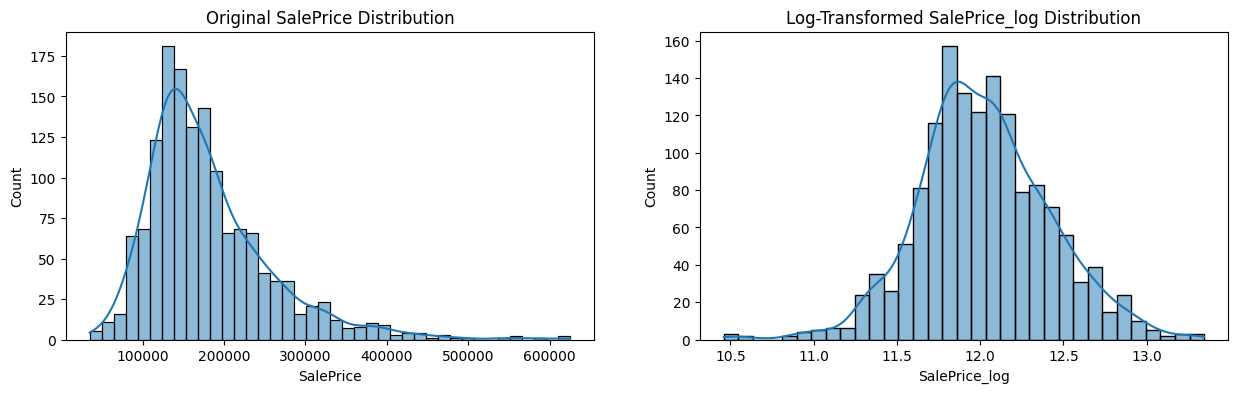

In [12]:
## Point 3

transformed_to_log_target_column = f"{target_column}_log"

train_dataset_cleaned[transformed_to_log_target_column] = np.log1p(train_dataset_cleaned[target_column])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# Plot original SalePrice distribution on the first subplot
sns.histplot(train_dataset_cleaned[target_column], kde=True, ax=axes[0])
axes[0].set_title(f"Original {target_column} Distribution")

# Plot log-transformed SalePrice distribution on the second subplot
sns.histplot(train_dataset_cleaned[transformed_to_log_target_column], kde=True, ax=axes[1])
axes[1].set_title(f"Log-Transformed {transformed_to_log_target_column} Distribution")

plt.show()

To encode the features, we have to be aware of the different types that are present in the dataset. We have two types (1) **Ordinal** and (2) **Nominal** features.

**Ordinal** features have an intrinsic order. For example we observe that many features in the dataset refer to "Quality of X", like "ExterQual", "BsmtQual", etc that is ordered from (NA - No X, Po - Poor quality, Fa - Fair quality, TA - typical quality, Gd - good quality and Ex - excellent quality. We will map these values to a 0-5 and encode them using **Ordinal Encoding**.

**Nominal** features are categories to which the feature is assigned to. For example the **Neighborhood**, which represents the physical location of the house in the city, can assume different values dependending, of course, by the neighboorhood the house is in.

### 2.4 Encoding

In [13]:
## Point 4 - Ordinal
from sklearn.preprocessing import OrdinalEncoder

# --- Define categories and columns ---
qual_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']
qual_cats = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
bsmt_fin_cols = ['BsmtFinType1', 'BsmtFinType2']
bsmt_fin_cats = ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
bsmt_exp_cols = ['BsmtExposure']
bsmt_exp_cats = ['None', 'No', 'Mn', 'Av', 'Gd']
garage_fin_cols = ['GarageFinish']
garage_fin_cats = ['None', 'Unf', 'RFn', 'Fin']
paved_drive_cols = ['PavedDrive']
paved_drive_cats = ['N', 'P', 'Y']
land_slope_cols = ['LandSlope']
land_slope_cats = ['Sev', 'Mod', 'Gtl']

# --- Initialize all encoders ---
qual_encoder = OrdinalEncoder(categories=[qual_cats] * len(qual_cols), handle_unknown='use_encoded_value', unknown_value=-1)
bsmt_fin_encoder = OrdinalEncoder(categories=[bsmt_fin_cats] * len(bsmt_fin_cols), handle_unknown='use_encoded_value', unknown_value=-1)
bsmt_exp_encoder = OrdinalEncoder(categories=[bsmt_exp_cats], handle_unknown='use_encoded_value', unknown_value=-1)
garage_fin_encoder = OrdinalEncoder(categories=[garage_fin_cats], handle_unknown='use_encoded_value', unknown_value=-1)
paved_drive_encoder = OrdinalEncoder(categories=[paved_drive_cats], handle_unknown='use_encoded_value', unknown_value=-1)
land_slope_encoder = OrdinalEncoder(categories=[land_slope_cats], handle_unknown='use_encoded_value', unknown_value=-1)

# --- Fit and Transform the Training Data ---
# Note: We fill NaNs with a default value just before fitting/transforming
train_dataset_cleaned[qual_cols] = qual_encoder.fit_transform(train_dataset_cleaned[qual_cols])
train_dataset_cleaned[bsmt_fin_cols] = bsmt_fin_encoder.fit_transform(train_dataset_cleaned[bsmt_fin_cols])
train_dataset_cleaned[bsmt_exp_cols] = bsmt_exp_encoder.fit_transform(train_dataset_cleaned[bsmt_exp_cols])
train_dataset_cleaned[garage_fin_cols] = garage_fin_encoder.fit_transform(train_dataset_cleaned[garage_fin_cols])
train_dataset_cleaned[paved_drive_cols] = paved_drive_encoder.fit_transform(train_dataset_cleaned[paved_drive_cols])
train_dataset_cleaned[land_slope_cols] = land_slope_encoder.fit_transform(train_dataset_cleaned[land_slope_cols])

# --- Transform the Test Data (filling NaNs with the same strategy) ---
test_dataset_cleaned[qual_cols] = qual_encoder.transform(test_dataset_cleaned[qual_cols])
test_dataset_cleaned[bsmt_fin_cols] = bsmt_fin_encoder.transform(test_dataset_cleaned[bsmt_fin_cols])
test_dataset_cleaned[bsmt_exp_cols] = bsmt_exp_encoder.transform(test_dataset_cleaned[bsmt_exp_cols])
test_dataset_cleaned[garage_fin_cols] = garage_fin_encoder.transform(test_dataset_cleaned[garage_fin_cols])
test_dataset_cleaned[paved_drive_cols] = paved_drive_encoder.transform(test_dataset_cleaned[paved_drive_cols])
test_dataset_cleaned[land_slope_cols] = land_slope_encoder.transform(test_dataset_cleaned[land_slope_cols])

In [14]:
train_dataset_cleaned.sample(8, random_state=random_state)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_log
Id,,,,,,,,,,,,,,,,,,,,,
1243,85,RL,85.0,10625,Pave,None,Reg,Lvl,AllPub,Inside,...,None,MnPrv,None,0,1,2010,WD,Family,170000,12.043560
1186,50,RL,60.0,9738,Pave,None,Reg,Lvl,AllPub,Inside,...,None,None,None,0,3,2006,WD,Normal,104900,11.560772
1258,30,RL,56.0,4060,Pave,None,Reg,Lvl,AllPub,Corner,...,None,None,None,0,7,2009,WD,Normal,99900,11.511935
1254,60,RL,69.0,17542,Pave,None,IR1,Lvl,AllPub,Inside,...,None,MnPrv,None,0,7,2007,WD,Normal,294000,12.591338
1221,20,RL,66.0,7800,Pave,None,IR1,Lvl,AllPub,Inside,...,None,None,None,0,11,2006,WD,Abnorml,115000,11.652696
1320,20,RL,75.0,10215,Pave,None,Reg,Bnk,AllPub,Inside,...,None,None,None,0,2,2007,WD,Normal,111000,11.617294
172,20,RL,141.0,31770,Pave,None,IR1,Lvl,AllPub,Corner,...,None,None,None,0,5,2010,WD,Normal,215000,12.278398
958,20,RL,70.0,7420,Pave,None,Reg,Lvl,AllPub,Inside,...,None,None,None,0,4,2007,WD,Normal,132000,11.790565


In [15]:
## Point 4 - Nominal

from sklearn.preprocessing import OneHotEncoder

df_final = train_dataset_cleaned.copy()
df_test_final = test_dataset_cleaned.copy()

df_final['MSSubClass'] = df_final['MSSubClass'].astype(str)
df_test_final['MSSubClass'] = df_test_final['MSSubClass'].astype(str)

nominal_cols = df_final.select_dtypes(include=['object']).columns
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Fit on the training data and transform it
encoded_train = ohe.fit_transform(df_final[nominal_cols])
encoded_df_train = pd.DataFrame(encoded_train, index=df_final.index, columns=ohe.get_feature_names_out(nominal_cols))

# ONLY transform the test data
encoded_test = ohe.transform(df_test_final[nominal_cols])
encoded_df_test = pd.DataFrame(encoded_test, index=df_test_final.index, columns=ohe.get_feature_names_out(nominal_cols))

# Drop, concat, and align
df_final.drop(nominal_cols, axis=1, inplace=True)
df_test_final.drop(nominal_cols, axis=1, inplace=True)
df_final = pd.concat([df_final, encoded_df_train], axis=1)
df_test_final = pd.concat([df_test_final, encoded_df_test], axis=1)

# also process the missing values on the test dataset after encoding the features
test_nan_cols = df_test_final.columns[df_test_final.isna().any()].tolist()

for col in test_nan_cols:
    median_value = df_final[col].median()
    df_test_final[col] = df_final[col].fillna(median_value)
    print(f"Filled NaNs in '{col}' with training data median for test dataset: {median_value}")

Filled NaNs in 'BsmtFinSF1' with training data median for test dataset: 381.0
Filled NaNs in 'BsmtFinSF2' with training data median for test dataset: 0.0
Filled NaNs in 'BsmtUnfSF' with training data median for test dataset: 479.0
Filled NaNs in 'TotalBsmtSF' with training data median for test dataset: 991.0
Filled NaNs in 'BsmtFullBath' with training data median for test dataset: 0.0
Filled NaNs in 'BsmtHalfBath' with training data median for test dataset: 0.0
Filled NaNs in 'GarageCars' with training data median for test dataset: 2.0
Filled NaNs in 'GarageArea' with training data median for test dataset: 479.0


/Users/ilcors-dev/src/unibo/corsetti-house_prices_advanced_regression_techniques/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 6, 15, 16, 22, 27] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [16]:
df_final.sample(8, random_state=random_state)

,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1243,85.0,10625,2.0,7,6,1974,1974,81.0,3.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1186,60.0,9738,2.0,5,7,1924,1950,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1258,56.0,4060,2.0,5,8,1922,1950,0.0,3.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1254,69.0,17542,2.0,7,7,1974,2003,0.0,4.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1221,66.0,7800,2.0,5,5,1964,1964,0.0,3.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1320,75.0,10215,2.0,4,5,1954,1954,132.0,3.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
172,141.0,31770,2.0,6,5,1960,1960,112.0,3.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
958,70.0,7420,2.0,5,5,1962,1962,0.0,3.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# 3. Train & Evaluate

Now that we have a clean dataset, we can train some models and evaluate them using **Root Mean Squared Error (RMSE)**, **R-squared**.

Going step by step, here's how we are going to split the work:
1. **Prepare Data for Modeling**: We will separate our data into a feature matrix (X) and a target vector (y). We will then split these into a training set (for teaching the models) and a validation set (for evaluating their performance on unseen data).

2. **Establish a Baseline Model**: We'll start by training a simple and interpretable **Ridge Regression** model. This will give us a baseline performance score that we can strive to improve upon.

3. **Train Advanced Models**: We will then train two more powerful models: a **Random Forest Regressor** and an **XGBoost Regressor**.

4. **Evaluate and Compare Models**: Finally, we will compare the performance of all three models using **Root Mean Squared Error (RMSE)** and **R-squared** on the validation set. This will help us determine which model is the most accurate and best suited for this challenge.

Why do we use **RMSE** and **R-squared**?

**RMSE**, tells us the distance between the model's predictions and the actual values.
$$\mathrm{error}=\mathrm{actual}-\mathrm{predicted}$$
$$\mathrm{MSE}=\frac{1}{n}\sum_{i=1}^{n}(\mathrm{actual}-\mathrm{predicted})^2$$
$$\mathrm{RMSE}=\sqrt{\mathrm{MSE}}=\sqrt{\frac{1}{n}\sum_{i=1}^{n}(\mathrm{actual}-\mathrm{predicted})^2}$$
In our case, it tells how much of, on average, our prediction is off by log-dollars. For example, if we get a **RMSE** of $0.13$, it means that on average our model prediction is off by $0.13$ log scaled dollars.

**The lower the better** because we want to minimize our prediction error.

**R-squared**, tells us how good our model fits the data by measuring the proportion of the variance in the target variable that gets explained by our model. It does so by comparing our model's performance to a baseline model that just predicts the mean value of the target for every observation.
$$\mathrm{SS}_{\mathrm{res}}(\mathrm{Sum\ of\ squared\ residuals})=\sum{i=1}^{n}(\mathrm{actual}-\mathrm{prediction})^2$$
$$\mathrm{SS}_{\mathrm{tot}}(\mathrm{Total\ sum\ of\ squares})=\sum{i=1}^{n}(\mathrm{actual}-\mathrm{mean})^2$$
$$R^2=1-\frac{\mathrm{SS}_{\mathrm{res}}}{\mathrm{SS}_{\mathrm{tot}}}$$

where:
- $\mathrm{SS}_{\mathrm{res}}(\mathrm{Sum\ of\ squared\ residuals})$ represents the errors of our model
- $\mathrm{SS}_{\mathrm{tot}}(\mathrm{Total\ sum\ of\ squares})$ represents the errors of the _mean-only_ model (the baseline)

In our case, it tells us **how well** our model accounts for the variation in the data. For example, if we get a **R-squared** of $0.86$, it means that our model can explain $86\%$ of the variation of the house prices.

**The higher the better** because it means that our model can explain the complexity of the data well.

## 3.1 Data preparation

In [17]:
from sklearn.model_selection import train_test_split

X = df_final.copy().drop([target_column, transformed_to_log_target_column], axis=1, errors='ignore')
y = df_final.copy()[transformed_to_log_target_column]

X_test_final = df_test_final.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_state)

print(f"Shape of the original unsplitted dataset {X.shape}")
print(f"Shape of the splitted train dataset {X_train.shape}")
print(f"Shape of the splitted test dataset {X_test.shape}")

Shape of the original unsplitted dataset (1455, 226)
Shape of the splitted train dataset (1164, 226)
Shape of the splitted test dataset (291, 226)


In [18]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

models = {
    'ridge': {
        'model': None,
        'prediction': None,
        'metrics': {}
    },
    'ridge_best': {
        'model': None,
        'prediction': None,
        'metrics': {}
    },
    'random_forest': {
        'model': None,
        'prediction': None,
        'metrics': {}
    },
    'random_forest_best': {
        'model': None,
        'prediction': None,
        'metrics': {}
    },
    'xgboost': {
        'model': None,
        'prediction': None,
        'metrics': {}
    },
    'xgboost_best': {
        'model': None,
        'prediction': None,
        'metrics': {}
    }
}

def compare_models(models_to_evaluate):
    """
    Creates a dictionary to compare the trained models.

    Args:
    models_to_evaluate (dict): A dictionary where keys are model names
                                and values are instantiated model objects.

    Returns:
        pd.DataFrame: A DataFrame with the RMSE and R2 scores for each model.
    """
    cv_results = {}

    for name, model_dict in models_to_evaluate.items():
        if 'rmse' not in model_dict['metrics'] or 'r2' not in model_dict['metrics']:
            continue
        
        cv_results[name] = {
            'rmse': model_dict['metrics']['rmse'],
            'r2': model_dict['metrics']['r2']
        }

    results_df = pd.DataFrame.from_dict(cv_results, orient='index').sort_values(['rmse', 'r2'], ascending=[True, False])

    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
      
    sns.barplot(y=results_df.index, x='rmse', data=results_df, ax=axes[0], palette='viridis', hue=results_df.index, legend=False)
    axes[0].set_title('Model RMSE Comparison (lower is best)')
    axes[0].set_xlabel('RMSE')
    axes[0].set_ylabel('Model')
    
    min_rmse = results_df['rmse'].min()
    max_rmse = results_df['rmse'].max()
    axes[0].set_xlim(min_rmse * 0.95, max_rmse * 1.05)
      
    sns.barplot(y=results_df.index, x='r2', data=results_df, ax=axes[1], palette='viridis', hue=results_df.index, legend=False)
    axes[1].set_title('Model R2 Score Comparison (higher is best)')
    axes[1].set_xlabel('R2 Score')
    axes[1].set_ylabel('Model')
    
    min_r2 = results_df['r2'].min()
    max_r2 = results_df['r2'].max()
    axes[1].set_xlim(min_r2 * 0.95, max(1.0, max_r2 * 1.05))
      
    plt.tight_layout()
    plt.show()

    return results_df

## 3.2 Training a Baseline model

Let's now go on training the **Rigde Regression** model. Why? We want to come to an acceptable solution by starting with a simple model and building upon it to improve the predictions. There are a bunch of models that are deemed *simple* like the **Linear Regressor** or the **Ridge Regressor**.

The **Linear Regressor** goal is to minimize the "sum of squared errors" (SSE), that is having a cost function associated of this form

$$\min(\sum{(\mathrm{actual\_target} - \mathrm{predicted\_target})^2)}$$

In other words the model tries to find the specific slope (coefficient) for each feature that makes this total sum as little as possible.
Since our dataset has many features columns, the **Linear Regressor** does not perform well because in case of highly correlated features the model may decide to give more weight to one feature (assigning a large coefficient) while assigning a negative weight to a similar correlated feature (exploding coefficients). In the end this could lead to an unstable model which may perform really well on the train data but poorly on new unseen data (overfitting).

On the other hand, the goal of **Ridge Regressor** is the same as the **Linear Regressor** but it assigns a penalty to the coefficients that are assigned to be too large by adding a **regularization term** to the cost function. This term represents the sum of the squares of all the feature coefficients multiplied by an alpha ($\alpha$) value.

$$\min(\sum\mathrm{actual\_target} - \mathrm{predicted\_target}^2 + \alpha\cdot\sum{\mathrm{all\_feature\_coefficients}^2})$$

With this, the model still aims to fit the training data well, but it is also incentivized to keep the coefficients small to minimize the penalty that would be assigned.
The $\alpha$ is an hyperparameter that is set by us:
- if $\alpha = 0$: the **Ridge Regressor** acts like a standard **Linear Regressor**
- if $\alpha$ is very large: the penalty is severe, meaning that the model will keep the coefficients really small to avoid the penalty, which leads to fitting the training data a bit worse (underfitting)

We therefore want to set an $\alpha$ that is something in between to avoid overfitting (exploding coefficients) and underfitting (making coefficients really small)

In [19]:
from sklearn.linear_model import Ridge

models['ridge']['model'] = Ridge(alpha=1.0, random_state=random_state)

models['ridge']['model'].fit(X_train, y_train)

models['ridge']['prediction'] = models['ridge']['model'].predict(X_test)

models['ridge']['metrics']['mse'] = mean_squared_error(y_test, models['ridge']['prediction'])
models['ridge']['metrics']['rmse'] = np.sqrt(models['ridge']['metrics']['mse'])
models['ridge']['metrics']['r2'] = r2_score(y_test, models['ridge']['prediction'])

print("--- Ridge Regression Baseline ---")
print(f"RMSE: {models['ridge']['metrics']['rmse']:.4f}")
print(f"R-squared: {models['ridge']['metrics']['r2']:.4f}")

--- Ridge Regression Baseline ---
RMSE: 0.1137
R-squared: 0.9178


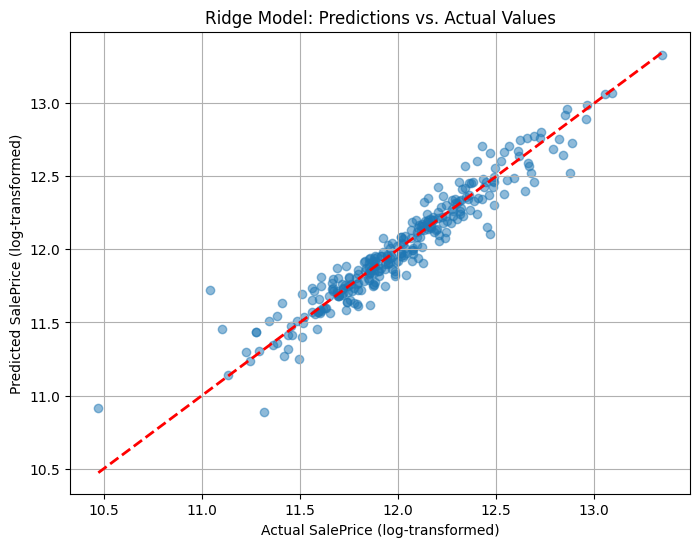

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, models['ridge']['prediction'], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Perfect prediction line

plt.xlabel("Actual SalePrice (log-transformed)")
plt.ylabel("Predicted SalePrice (log-transformed)")
plt.title("Ridge Model: Predictions vs. Actual Values")
plt.grid(True)
plt.show()

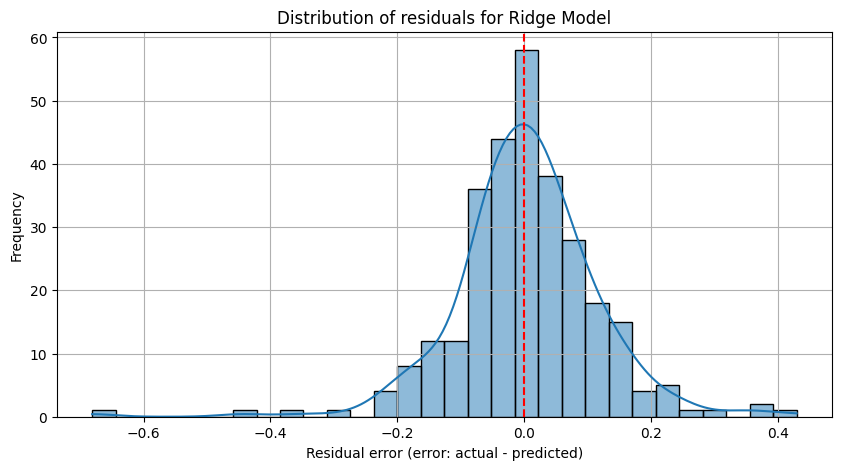

In [21]:
models['ridge']['residuals'] = y_test - models['ridge']['prediction']

plt.figure(figsize=(10, 5))
sns.histplot(models['ridge']['residuals'], bins=30, kde=True)

plt.axvline(x=0, color='r', linestyle='--')

plt.title("Distribution of residuals for Ridge Model")
plt.xlabel("Residual error (error: actual - predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Our initial baseline model, was trained to establish a performance benchmark. The model performed well, achieving an R-squared value of **0.9178**. This indicates that our model can explain approximately 91.8% of the variance in the log-transformed sale prices, which points to a very strong fit.

The RMSE was **0.1137**. This means that on the log-transformed scale, our model's predictions are, on average, off by about **0.11** log-scaled dollars.

### 3.2.1 Finetuning

Since we need to set the hyperparameter $\alpha$, it's a good idea to finetune the model with **GridSearchCV** to find the best one.

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': np.logspace(-2, 3, 20) # generates a list of values from .01 to 1000
}

ridge_grid_search = GridSearchCV(
    estimator=Ridge(random_state=random_state),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error' # take the negative of mse since GridSearchCV works by taking the best the highest value out of the estimation
)

ridge_grid_search.fit(X_train, y_train)

models['ridge_best']['model'] = ridge_grid_search.best_estimator_

print(f"Best alpha hyperparameter found {models['ridge_best']['model'].alpha}")

models['ridge_best']['prediction'] = models['ridge_best']['model'].predict(X_test)

models['ridge_best']['metrics']['mse'] = mean_squared_error(y_test, models['ridge_best']['prediction'])
models['ridge_best']['metrics']['rmse'] = np.sqrt(models['ridge_best']['metrics']['mse'])
models['ridge_best']['metrics']['r2'] = r2_score(y_test, models['ridge_best']['prediction'])

print(f"RMSE: {models['ridge_best']['metrics']['rmse']:.4f}")
print(f"R-squared: {models['ridge_best']['metrics']['r2']:.4f}")

Best alpha hyperparameter found 26.366508987303583
RMSE: 0.1127
R-squared: 0.9192


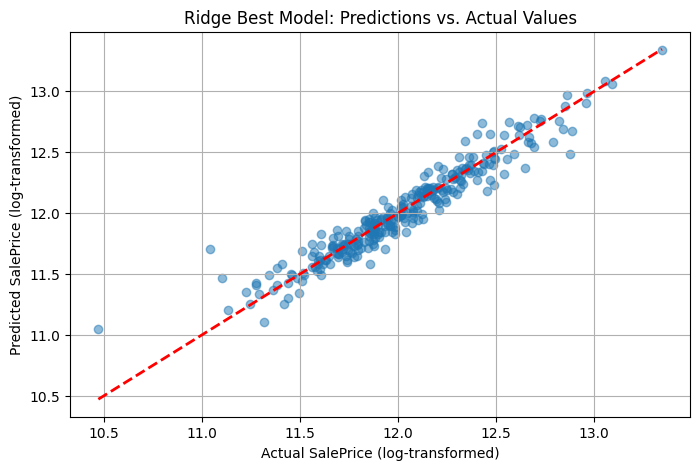

In [23]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, models['ridge_best']['prediction'], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Perfect prediction line

plt.xlabel("Actual SalePrice (log-transformed)")
plt.ylabel("Predicted SalePrice (log-transformed)")
plt.title("Ridge Best Model: Predictions vs. Actual Values")
plt.grid(True)
plt.show()

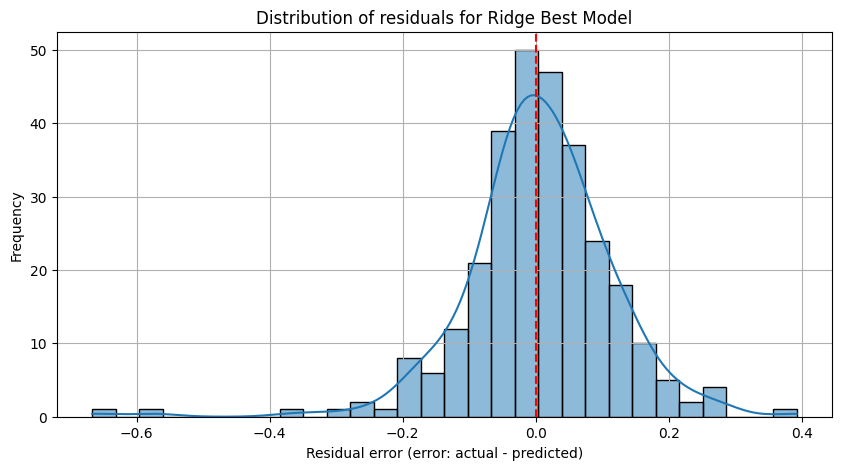

In [24]:
models['ridge_best']['residuals'] = y_test - models['ridge_best']['prediction']

plt.figure(figsize=(10, 5))
sns.histplot(models['ridge_best']['residuals'], bins=30, kde=True)

plt.axvline(x=0, color='r', linestyle='--')

plt.title("Distribution of residuals for Ridge Best Model")
plt.xlabel("Residual error (error: actual - predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

We found a slightly better model with $\alpha=26.366508987303583$, a slightly lower RMSE and higher R-squared.

## 4. Advanced Models

Our tuned **Ridge Regression** model provided a strong linear baseline, but the relationships between the features and the sale price are likely more complex and non-linear. To capture these intricate patterns and potentially improve our predictive accuracy, we will now explore two powerful ensemble models: **Random Forest** and **XGBoost**.

- **Random Forest Regressor**: This model operates by building a multitude of decision trees and averaging their predictions. This approach makes it robust, less prone to overfitting than a single tree, and excellent at modeling complex interactions.

- **XGBoost Regressor**: This is a leading implementation of gradient boosting, an algorithm that builds models sequentially, with each new model correcting the errors of its predecessor.

By training and evaluating these models, we can determine if a more complex, non-linear approach yields a significant improvement over our initial Ridge baseline.

### 4.1 Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor

models['random_forest']['model'] = RandomForestRegressor(random_state=random_state)

models['random_forest']['model'].fit(X_train, y_train)

models['random_forest']['prediction'] = models['random_forest']['model'].predict(X_test)

models['random_forest']['metrics']['mse'] = mean_squared_error(y_test, models['random_forest']['prediction'])
models['random_forest']['metrics']['rmse'] = np.sqrt(models['random_forest']['metrics']['mse'])
models['random_forest']['metrics']['r2'] = r2_score(y_test, models['random_forest']['prediction'])

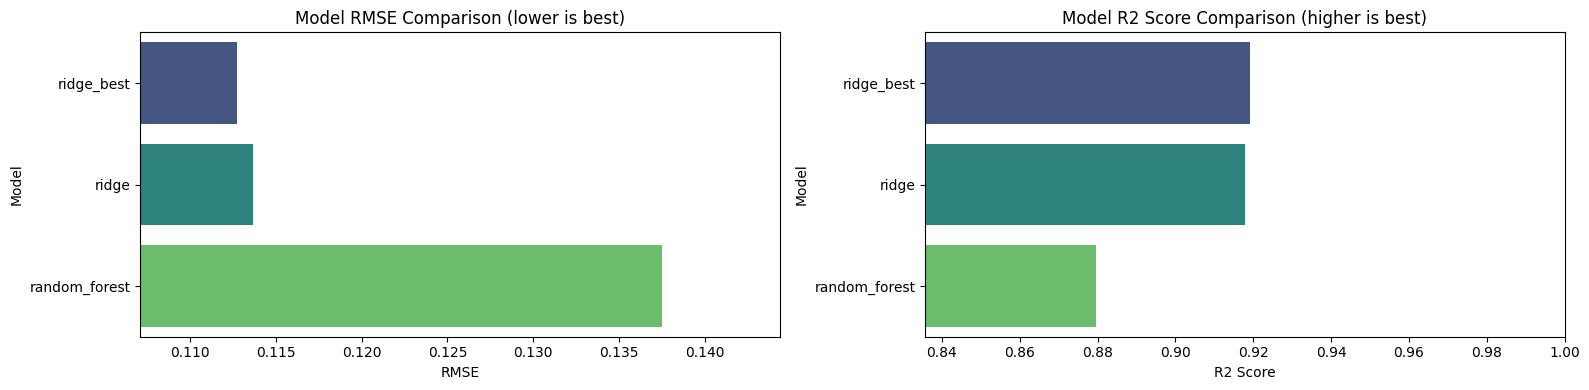

,rmse,r2
ridge_best,0.112727,0.919156
ridge,0.113688,0.917771
random_forest,0.137517,0.879688


In [26]:
compare_models(models)

In [27]:
models['random_forest']['model'].estimator

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


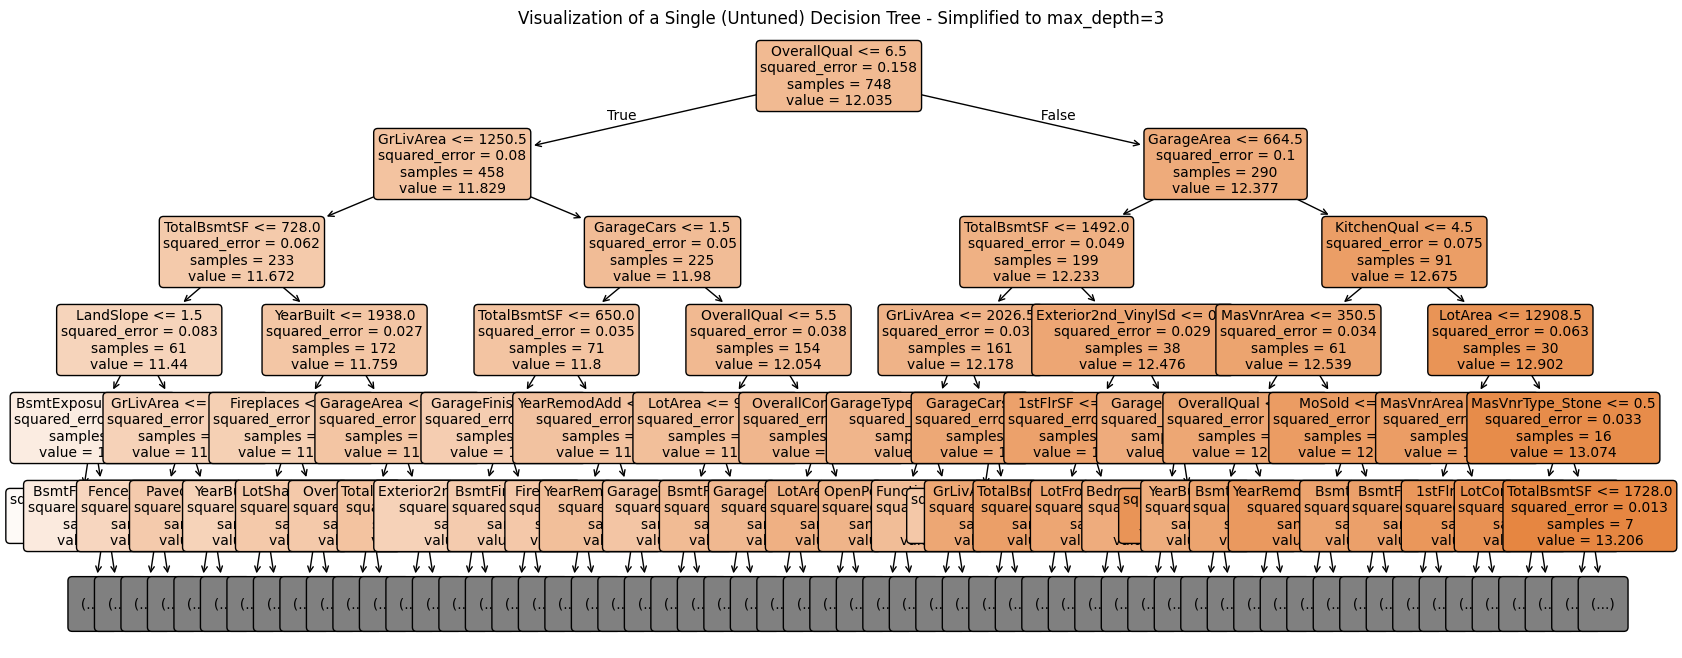

In [28]:
from sklearn.tree import plot_tree

tree = models['random_forest']['model'].estimators_[0]

plt.figure(figsize=(20, 8))
plot_tree(tree,
          feature_names=X.columns,
          filled=True,
          rounded=True,
          max_depth=5,
          fontsize=10)
plt.title("Visualization of a Single (Untuned) Decision Tree - Simplified to max_depth=3")
plt.show()

As we can see, our tuned **Ridge Regressor** performs better than this newly trained model. It's expected since we have not yet looked for the optimal parameters for this regressor.

#### 4.1.1 Finetuning

In [29]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1.0, 'sqrt']
}

rf_random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=random_state),
    param_distributions=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=random_state
)

rf_random_search.fit(X_train, y_train)

models['random_forest_best']['model'] = rf_random_search.best_estimator_

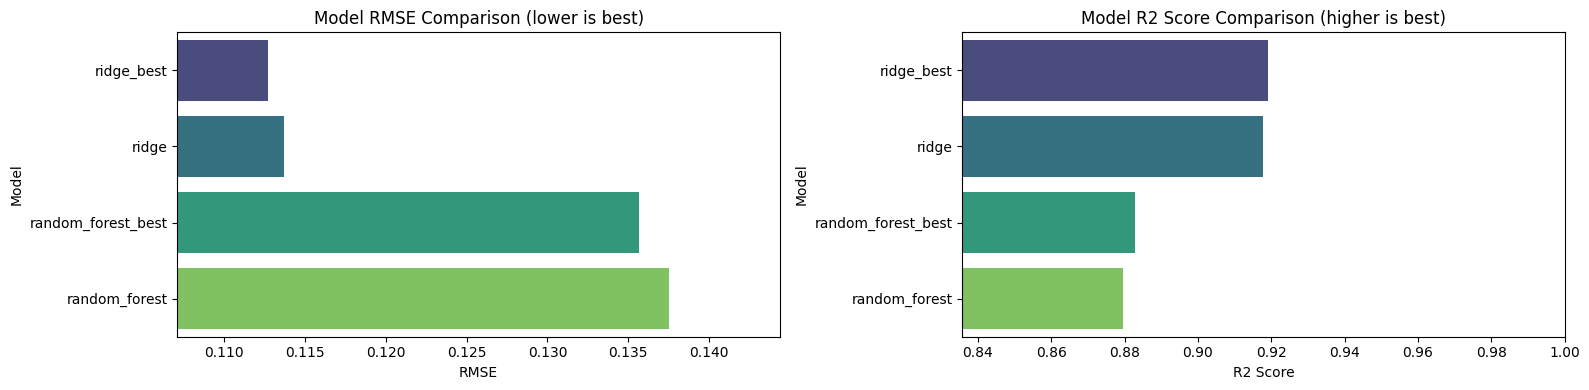

,rmse,r2
ridge_best,0.112727,0.919156
ridge,0.113688,0.917771
random_forest_best,0.135646,0.882939
random_forest,0.137517,0.879688


In [30]:
models['random_forest_best']['prediction'] = models['random_forest_best']['model'].predict(X_test)

models['random_forest_best']['metrics']['mse'] = mean_squared_error(y_test, models['random_forest_best']['prediction'])
models['random_forest_best']['metrics']['rmse'] = np.sqrt(models['random_forest_best']['metrics']['mse'])
models['random_forest_best']['metrics']['r2'] = r2_score(y_test, models['random_forest_best']['prediction'])

compare_models(models)

We can conclude that our tuned Ridge model is a very strong and effective baseline. Any more complex model must prove that it is significantly better to justify its added complexity. Our tuned **Random Forest** failed to do this. Also, maybe the different features of the dataset are more linear than we thought they would be!

### 4.2 XGBoost

Let's try to train another model, **XGBoost** (eXtreme Gradient Boosting). This tree-based model works by building multiple models, each new one improving the last one. In other words (1) it starts with a simple model which will predict quite poorly, (2) the algorithm calculates the "how wrong" the prediction was for each house

$$\mathrm{Error}=\mathrm{actual\_value} - \mathrm{predicted\_value},$$
$$> 0, \mathrm{if\ prediction\ is\ lower\ than\ actual}$$
$$< 0, \mathrm{if\ prediction\ is\ greater\ than\ actual}$$

(3) train a new model not to predict the target variable, but to predict the calculated error (basically trying to fix the previous model errors), (4) add this new model prediction to the previous one, using an hyperparameter called $\mathrm{learning\_rate}$ which is used to tell the model "how much the correction should be trusted". For example, a value of $1.0$, will tell the model that the correction made by this new model is 100% trust-worthy, which can improve training speed but could make the model learn noise instead of actual patterns.

$$\mathrm{new\_prediction}=\mathrm{old\_prediction} + (\mathrm{learning\_rate}\cdot\mathrm{error\_tree\_prediction})$$

In [31]:
import xgboost as xgb

models['xgboost']['model'] = xgb.XGBRegressor(random_state=random_state)

models['xgboost']['model'].fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


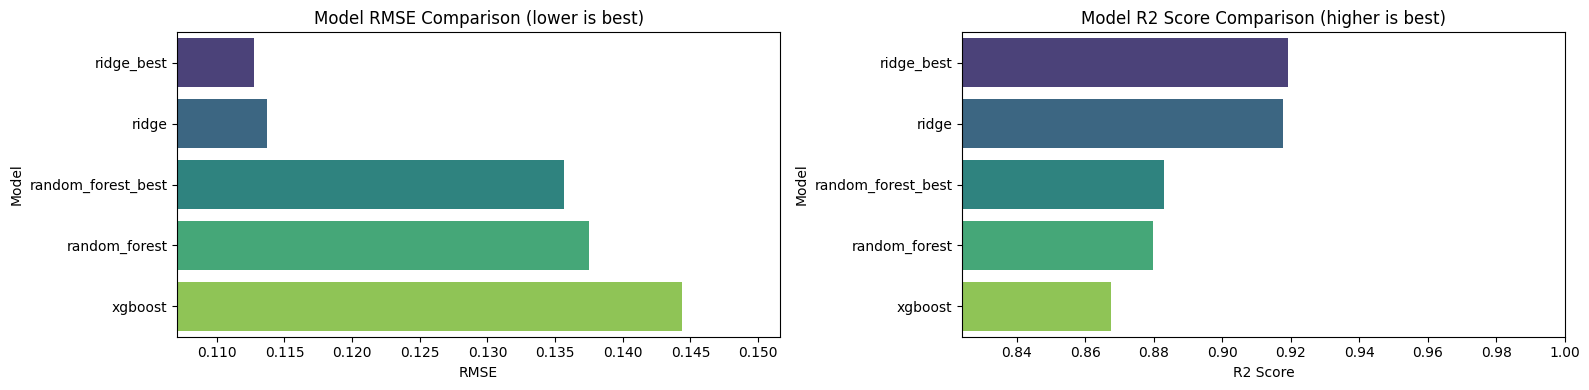

,rmse,r2
ridge_best,0.112727,0.919156
ridge,0.113688,0.917771
random_forest_best,0.135646,0.882939
random_forest,0.137517,0.879688
xgboost,0.144381,0.867377


In [32]:
models['xgboost']['prediction'] = models['xgboost']['model'].predict(X_test)

models['xgboost']['metrics']['mse'] = mean_squared_error(y_test, models['xgboost']['prediction'])
models['xgboost']['metrics']['rmse'] = np.sqrt(models['xgboost']['metrics']['mse'])
models['xgboost']['metrics']['r2'] = r2_score(y_test, models['xgboost']['prediction'])

compare_models(models)

#### 4.2.1 Finetuning

The **Tuned Ridge** regressor is still the best performing model here. Let's see if we can optimize the **XGBoost** model

In [33]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0]
}

xgb_grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=random_state),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

xgb_grid_search.fit(X_train, y_train)

models['xgboost_best']['model'] = xgb_grid_search.best_estimator_

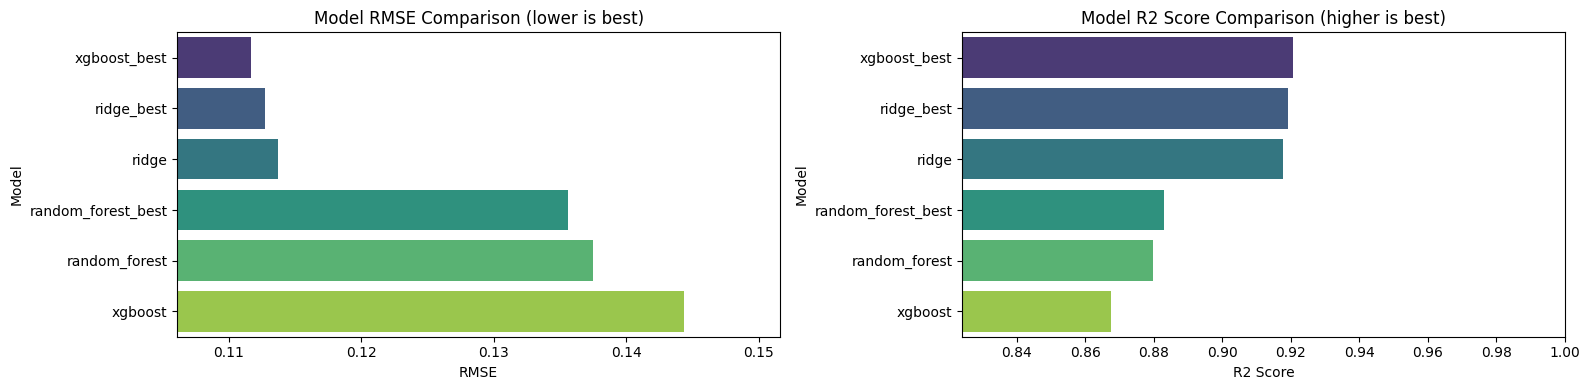

,rmse,r2
xgboost_best,0.111714,0.920602
ridge_best,0.112727,0.919156
ridge,0.113688,0.917771
random_forest_best,0.135646,0.882939
random_forest,0.137517,0.879688
xgboost,0.144381,0.867377


In [34]:
models['xgboost_best']['prediction'] = models['xgboost_best']['model'].predict(X_test)

models['xgboost_best']['metrics']['mse'] = mean_squared_error(y_test, models['xgboost_best']['prediction'])
models['xgboost_best']['metrics']['rmse'] = np.sqrt(models['xgboost_best']['metrics']['mse'])
models['xgboost_best']['metrics']['r2'] = r2_score(y_test, models['xgboost_best']['prediction'])

compare_models(models)

The tuned **XGBoost** model achieved the best **RMSE** and **R-squared**.

# 4. Results

In conclusion, we successfully executed all the steps we planned:
1. **Data Exploration**, where we took a look at the given dataset, discovering the correlation between features, discovering possible outliers and analysing the type of data.
2. **Data Cleaning**, where we applied our findings from point (1) to remove outliers, impute missing values, remove skewness of the target variable, convert categorical features with ordinal and one-hot encoding.
3. **Training and evaluation**, where we trained different models with different regressors, looking each time for the best parameters combination of each using GridSearchCV. In the end we found the best model to be XGBoost.

## 4.1 Final Step: Submission

What's left now is to get the best model we found, retrain it on the whole **train.csv** dataset and create a **submission.csv** dataset by inverting the log-based predictions back into the real unit in dollars and see how well we scored.

In [35]:
def select_best_model(models_dict):
    """
    Selects and prints the best model from the dictionary of saved models getting the one with lower rmse and higher r2.
    
    Args:
        models_dict (dict): A dictionary containing the trained models and their metrics.
    
    Returns:
        The best performing model object.
    """
    comparison = compare_models(models_dict)
    
    best_model_name = comparison.index[0]

    best_model = models_dict[best_model_name]

    print(f"Best model found {best_model_name}")
    print(best_model['metrics'])
    
    return best_model['model']

def create_submission(model, X_train_full, y_train_full, X_test_full, output_file_name='submission'):
    """
    Selects the best model, retrains it on the full dataset, handles any final
    data cleaning, and generates the submission.csv file.

    Args:
        models_dict (dict): Dictionary containing all trained and evaluated models.
        X_train_full (pd.DataFrame): The complete, aligned training feature set.
        y_train_full (pd.Series): The complete training target set.
        X_test_full (pd.DataFrame): The complete, aligned test feature set.
    """
    params = model.get_params()
    model_type_name = type(model).__name__

    model = None

    
    match model_type_name:
        case 'Ridge':
            model = Ridge(**params)
        case 'RandomForestRegressor':
            model = RandomForestRegressor(**params)
        case 'XGBRegressor':
            model = xgb.XGBRegressor(**params)
        case _:
            print(f"Error: Unhandled model type '{model_type_name}'")
            return

    if not model:
         return

    print(f"Final model for retraining: {model_type_name}")
    
    model.fit(X_train_full, y_train_full)
    print("Retraining complete.")
    
    X_test_prepared = X_test_full.copy()
    
    nan_cols = X_test_prepared.columns[X_test_prepared.isna().any()].tolist()

    for col in nan_cols:
         median_value = X_train_full[col].median()
         X_test_prepared[col] = X_test_prepared[col].fillna(median_value)
         print(f"Filled NaNs in '{col}' with training data median: {median_value}")
    
    print("Making predictions on the prepared test set...")
    final_predictions_log = model.predict(X_test_prepared)
    
    final_predictions = np.expm1(final_predictions_log)
    
    submission = pd.DataFrame({'Id': X_test_prepared.index, 'SalePrice': final_predictions})
    submission.to_csv(f'{output_file_name}.csv', index=False)
    
    print("submission.csv' has been created successfully!")
    print("Here are the first 5 predictions:")
    print(submission.head())

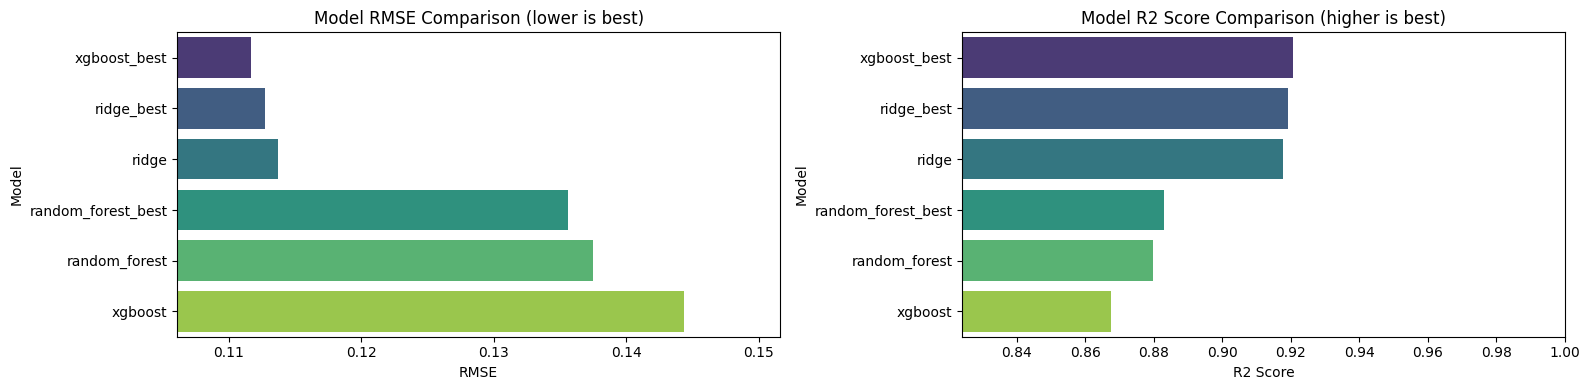

Best model found xgboost_best
{'mse': 0.012480020428009513, 'rmse': np.float64(0.11171401178012323), 'r2': 0.9206015347114854}
Final model for retraining: XGBRegressor
Retraining complete.
Filled NaNs in 'BsmtFinSF1' with training data median: 381.0
Filled NaNs in 'BsmtFinSF2' with training data median: 0.0
Filled NaNs in 'BsmtUnfSF' with training data median: 479.0
Filled NaNs in 'TotalBsmtSF' with training data median: 991.0
Filled NaNs in 'BsmtFullBath' with training data median: 0.0
Filled NaNs in 'BsmtHalfBath' with training data median: 0.0
Filled NaNs in 'GarageCars' with training data median: 2.0
Filled NaNs in 'GarageArea' with training data median: 479.0
Making predictions on the prepared test set...
submission.csv' has been created successfully!
Here are the first 5 predictions:
     Id      SalePrice
0  1461  122212.382812
1  1462  154279.921875
2  1463  184631.468750
3  1464  187498.406250
4  1465  180924.343750


In [36]:
X = df_final.copy().drop([target_column, transformed_to_log_target_column], axis=1, errors='ignore')
y = df_final.copy()[transformed_to_log_target_column]

X_test_final = df_test_final.copy()

X_train_final, X_test_final = X.align(X_test_final, join='inner', axis=1) # make sure the train and test dataset have the same

create_submission(select_best_model(models), X_train_final, y, X_test_final)

# 5. [Bonus] Improving our Kaggle score

Our solutions scores $0.12810$ [on Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/leaderboard#), which places us $1172$ on the leaderboard. Let's see if we can improve this.

Two things we can do is:
1. **Feature engineering**, which consists of creating new features based on the ones that are correlated with each other and retrain the models on this new dataset.
2. **Model ensembling**, which consists of using our best models predictions as new features upon which to train another model.

## 5.1 Feature Engineering

Looking deeper at the [data_description.txt](./data/data_description.txt) file, we can see that some features can be merged together:
- `TotalBsmtSF`, `1stFlrSF`, `2ndFlrSF` all represent the floors square feets.
- `FullBath`, `HalfBath`, `BsmtFullBath`, `BsmtHalfBath` all represents the baths present in the house and where they are.
- `OpenPorchSF`, `EnclosedPorch`, `3SsnPorch`, `ScreenPorch` all represent the porches square feets.
- `YrSold`, `YearBuilt` age related features
- `YrSold`, `YearRemodAdd` age related on reworking
- `YrSold` == `YearBuilt`, new house
- `YearRemodAdd` != `YearBuilt`, was reworked
- `OverallQual`, `TotalSF` relating the overall quality to the total square feets
- `OverallQual`, `HouseAge` relating the overall quality to the house age

In [37]:
def add_features(df):
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
    df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    df['RemodelAge'] = df['YrSold'] - df['YearRemodAdd']

    df['IsNew'] = (df['YrSold'] == df['YearBuilt']).astype(int)
    df['WasRemodeled'] = (df['YearRemodAdd'] != df['YearBuilt']).astype(int)

    df['OverallQual_x_TotalSF'] = df['OverallQual'] * df['TotalSF']
    df['OverallQual_x_HouseAge'] = df['OverallQual'] * df['HouseAge']

    return df

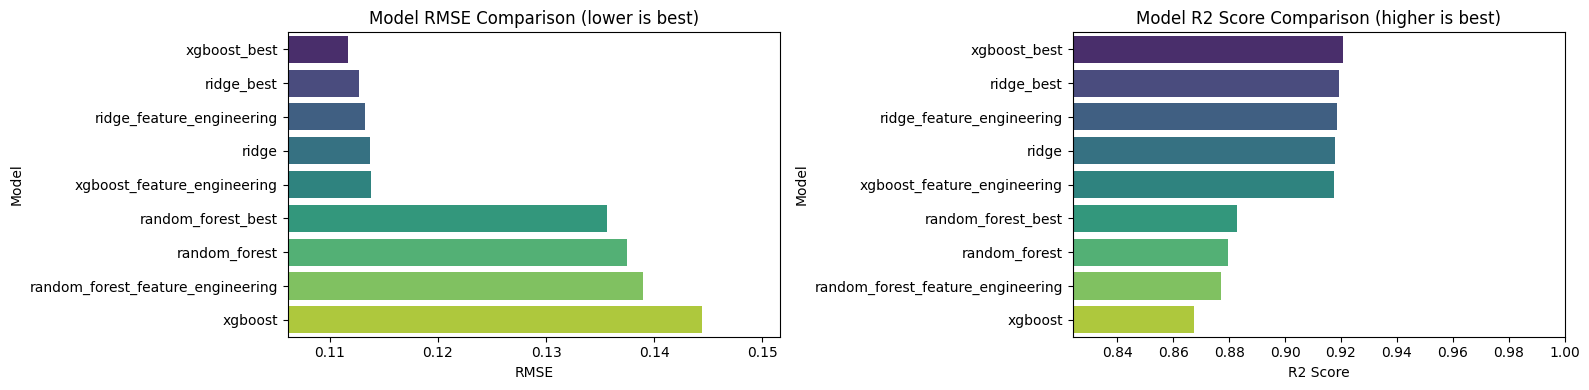

,rmse,r2
xgboost_best,0.111714,0.920602
ridge_best,0.112727,0.919156
ridge_feature_engineering,0.113245,0.918410
ridge,0.113688,0.917771
xgboost_feature_engineering,0.113850,0.917536
random_forest_best,0.135646,0.882939
random_forest,0.137517,0.879688
random_forest_feature_engineering,0.138983,0.877109
xgboost,0.144381,0.867377


In [38]:
train_dataset = add_features(df_final.copy())
test_dataset = add_features(df_test_final.copy())

X = train_dataset.copy().drop([target_column, transformed_to_log_target_column], axis=1, errors='ignore')
y = train_dataset.copy()[transformed_to_log_target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_state)

models_to_evaluate = {
    'ridge_feature_engineering': GridSearchCV(
        estimator=Ridge(random_state=random_state),
        param_grid={ 'alpha': np.logspace(-2, 3, 20) },
        cv=5,
        scoring='neg_mean_squared_error'
    ),
    'random_forest_feature_engineering': RandomizedSearchCV(
        estimator=RandomForestRegressor(random_state=random_state),
        param_distributions={
            'n_estimators': [100, 200, 300, 500],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': [1.0, 'sqrt']
        },
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=random_state
    ),
    'xgboost_feature_engineering': GridSearchCV(
        estimator=xgb.XGBRegressor(random_state=random_state),
        param_grid={
            'max_depth': [3, 4, 5],
            'learning_rate': [0.05, 0.1, 0.2],
            'n_estimators': [100, 200, 300],
            'subsample': [0.8, 1.0]
        },
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
}

for name, searcher in models_to_evaluate.items():
    models[name] = {
        'model': None,
        'prediction': None,
        'metrics': {}
    }

    searcher.fit(X_train, y_train)

    models[name]['model'] = searcher.best_estimator_
    models[name]['prediction'] = models[name]['model'].predict(X_test)
    
    models[name]['metrics']['mse'] = mean_squared_error(y_test, models[name]['prediction'])
    models[name]['metrics']['rmse'] = np.sqrt(models[name]['metrics']['mse'])
    models[name]['metrics']['r2'] = r2_score(y_test, models[name]['prediction'])

compare_models(models)

However this did not find a better model unfortunately, our best **xgboost_best** remains the best.

In [39]:
X = df_final.copy().drop([target_column, transformed_to_log_target_column], axis=1, errors='ignore')
y = df_final.copy()[transformed_to_log_target_column]

X_test_final = df_test_final.copy()

X_train_final, X_test_final = X.align(X_test_final, join='inner', axis=1) # make sure the train and test dataset have the same

create_submission(models['ridge_feature_engineering']['model'], X_train_final, y, X_test_final, output_file_name='submission_feature_engineered')

Final model for retraining: Ridge
Retraining complete.
Filled NaNs in 'BsmtFinSF1' with training data median: 381.0
Filled NaNs in 'BsmtFinSF2' with training data median: 0.0
Filled NaNs in 'BsmtUnfSF' with training data median: 479.0
Filled NaNs in 'TotalBsmtSF' with training data median: 991.0
Filled NaNs in 'BsmtFullBath' with training data median: 0.0
Filled NaNs in 'BsmtHalfBath' with training data median: 0.0
Filled NaNs in 'GarageCars' with training data median: 2.0
Filled NaNs in 'GarageArea' with training data median: 479.0
Making predictions on the prepared test set...
submission.csv' has been created successfully!
Here are the first 5 predictions:
     Id      SalePrice
0  1461  115551.721936
1  1462  147277.669182
2  1463  173289.044735
3  1464  197218.154716
4  1465  188098.595276


As a result, submitting the best model trained on the engineered features scores worse on Kaggle ($0.13214$) than our **xgboost_best** best submission.

## 5.2 Model Ensembling (Stacking)

**Stacking** is an advanced ensembling technique that involves combining the predictions from multiple different machine learning models. We use a "meta-model" that learns how to best combine the outputs of several "base models" to produce a final, often more accurate, prediction.

The main idea is to take multiple models with their strenghts and weaknesses and compensate the weaknesses with other models strenghts making our final model hopefully more robust.

To implement the stacking we need to ensure that the predictions used to train our meta-model are "clean" meaning the base models that generated them had not seen that same data during their own training. If we train and predict on the same data, our meta-model will learn from over-optimistic predictions and fail to generalize to new data.

We achieve this by generating predictions in two different ways:
1. For the **Training Set (Creating Meta-Features)**: We use **K-Fold cross-validation**. For **each fold**, we train our base models on the other **K-1 folds** and then make predictions on the held-out fold. We repeat this process for all folds until we have a complete set of predictions for our entire training dataset. These are called "out-of-fold" predictions, and they serve as the feature set to train our meta-model.
2. For the **Test Set (Creating the Submission)**: To generate predictions for the final, unseen test data, we train our base models on the **entire** training dataset. This allows each base model to learn from all the available information before making its final prediction on the test data. The meta-model then takes these predictions as input to generate the final submission file.

Processing base model 1/3: ridge_best...
Processing base model 2/3: xgboost_best...
Processing base model 3/3: random_forest_best...


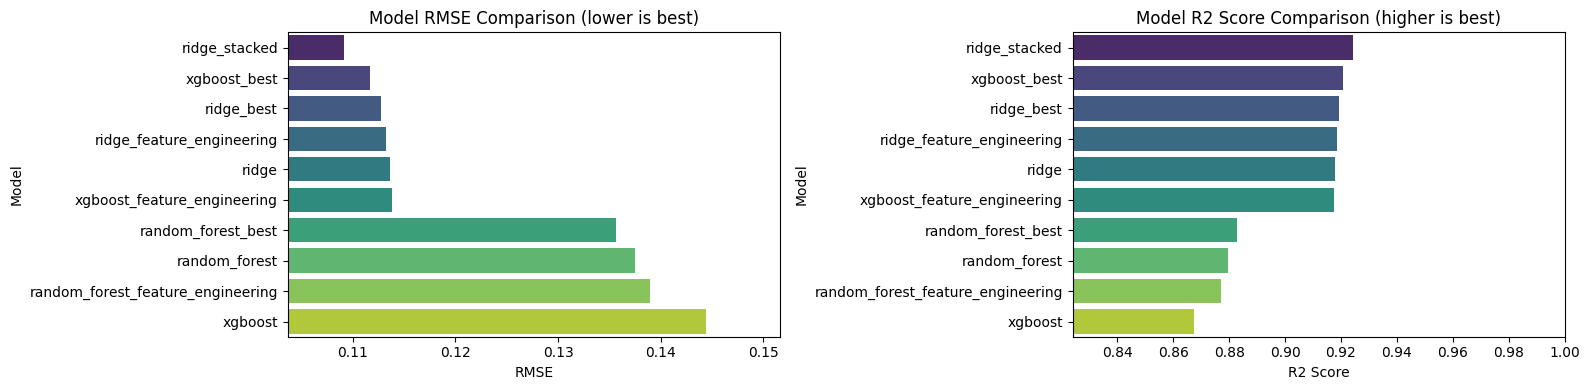

,rmse,r2
ridge_stacked,0.109142,0.924216
xgboost_best,0.111714,0.920602
ridge_best,0.112727,0.919156
ridge_feature_engineering,0.113245,0.918410
ridge,0.113688,0.917771
xgboost_feature_engineering,0.113850,0.917536
random_forest_best,0.135646,0.882939
random_forest,0.137517,0.879688
random_forest_feature_engineering,0.138983,0.877109
xgboost,0.144381,0.867377


In [40]:
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV

train_dataset = add_features(df_final.copy())
test_dataset = add_features(df_test_final.copy())

X = train_dataset.copy().drop([target_column, transformed_to_log_target_column], axis=1, errors='ignore')
y = train_dataset.copy()[transformed_to_log_target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_state)

base_models = [models['ridge_best']['model'], models['xgboost_best']['model'], models['random_forest_best']['model']]
base_model_names = ['ridge_best', 'xgboost_best', 'random_forest_best']

models['ridge_stacked'] = {
    'model': None,
    'prediction': None,
    'metrics': {}
}

models['ridge_stacked']['model'] = RidgeCV()

kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

meta_features_train = np.zeros((X_train.shape[0], len(base_models)))
meta_features_test = np.zeros((X_test.shape[0], len(base_models)))

for i, model in enumerate(base_models):
    print(f"Processing base model {i+1}/{len(base_models)}: {base_model_names[i]}...")

    # Create out-of-fold predictions for training data
    for train_idx, val_idx in kf.split(X_train):
        model.fit(X_train.values[train_idx], y_train.values[train_idx])
        meta_features_train[val_idx, i] = model.predict(X_train.values[val_idx])

    # Create predictions for test data (by fitting on full training data)
    model.fit(X_train, y_train)
    meta_features_test[:, i] = model.predict(X_test)

models['ridge_stacked']['model'].fit(meta_features_train, y_train)

models['ridge_stacked']['prediction'] = models['ridge_stacked']['model'].predict(meta_features_test)

models['ridge_stacked']['metrics']['mse'] = mean_squared_error(y_test, models['ridge_stacked']['prediction'])
models['ridge_stacked']['metrics']['rmse'] = rmse = np.sqrt(models['ridge_stacked']['metrics']['mse'])
models['ridge_stacked']['metrics']['r2'] = r2_score(y_test, models['ridge_stacked']['prediction'])

compare_models(models)

We can see that our **ridge_stacked** is the best performing model we trained so far!

In [ ]:
X_full_train = df_final.copy().drop([target_column, transformed_to_log_target_column], axis=1, errors='ignore')
y_full_train = df_final.copy()[transformed_to_log_target_column]
X_final_test = df_test_final.copy()

X_full_train, X_final_test = X_full_train.align(X_final_test, join='inner', axis=1)

test_nan_cols = X_final_test.columns[X_final_test.isna().any()].tolist()

for col in test_nan_cols:
    median_value = X_full_train[col].median()
    X_final_test[col] = X_final_test[col].fillna(median_value)
    print(f"Filled NaNs in '{col}' with training data median for test dataset: {median_value}")

print("Generating meta-features for the entire training set (out-of-fold)...")
meta_features_full_train = np.zeros((X_full_train.shape[0], len(base_models)))
meta_features_final_test = np.zeros((X_final_test.shape[0], len(base_models)))

for i, model in enumerate(base_models):
    print(f"Processing train meta-features with model {i+1}/{len(base_models)}: {base_model_names[i]}...")
    for train_idx, val_idx in kf.split(X_full_train):

        model.fit(X_full_train.iloc[train_idx], y_full_train.iloc[train_idx])
        # Predict on the validation fold
        meta_features_full_train[val_idx, i] = model.predict(X_full_train.iloc[val_idx])

for i, model in enumerate(base_models):
    print(f"Generating test meta-features with model {i+1}/{len(base_models)}...")
    # Fit on the ENTIRE training data
    model.fit(X_full_train, y_full_train)
    # Predict on the final test data
    meta_features_final_test[:, i] = model.predict(X_final_test)

print("Training the final stacked model on full meta-features...")

final_stacked_model = RidgeCV()
final_stacked_model.fit(meta_features_full_train, y_full_train)

final_predictions_log = final_stacked_model.predict(meta_features_final_test)

final_predictions = np.expm1(final_predictions_log)

submission_df = pd.DataFrame({'Id': X_final_test.index, 'SalePrice': final_predictions})
submission_df.to_csv('submission_stacked.csv', index=False)

print("File saved!")

Filled NaNs in 'BsmtFinSF1' with training data median for test dataset: 381.0
Filled NaNs in 'BsmtFinSF2' with training data median for test dataset: 0.0
Filled NaNs in 'BsmtUnfSF' with training data median for test dataset: 479.0
Filled NaNs in 'TotalBsmtSF' with training data median for test dataset: 991.0
Filled NaNs in 'BsmtFullBath' with training data median for test dataset: 0.0
Filled NaNs in 'BsmtHalfBath' with training data median for test dataset: 0.0
Filled NaNs in 'GarageCars' with training data median for test dataset: 2.0
Filled NaNs in 'GarageArea' with training data median for test dataset: 479.0
Generating meta-features for the entire training set (out-of-fold)...
Processing train meta-features with model 1/3: ridge_best...
Processing train meta-features with model 2/3: xgboost_best...
Processing train meta-features with model 3/3: random_forest_best...


And indeed submitting this on Kaggle results in our best-so-far score of $0.12624$.